In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
houses = pd.read_csv("./../src/data/raw/assessor.csv")
houses.head()

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Closed Roll Year,Property Location,Parcel Number,Block,Lot,Volume Number,Use Code,Use Definition,Property Class Code,Property Class Code Definition,...,Assessed Improvement Value,Assessed Land Value,Assessed Personal Property Value,Assessor Neighborhood District,Assessor Neighborhood Code,Assessor Neighborhood,Supervisor District,Analysis Neighborhood,the_geom,Row ID
0,2007.0,0000 0000 0000,1378007,1378,007,10,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,1.0,1D,Lake --The Presidio,1,Outer Richmond,POINT (-122.478111692066 37.785130177493),20071378007
1,2008.0,0000 0000 0000,1345001,1345,001,10,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,1.0,1D,Lake --The Presidio,2,Inner Richmond,POINT (-122.46850833548 37.787296873264),20081345001
2,2008.0,0000 0000 0000,5607046,5607,046,33,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,0,0,0,9.0,9A,Bernal Heights,9,Portola,POINT (-122.408022500468 37.737569794488),20085607046
3,2009.0,0000 0297 BALTIMORE WY0000,6499040,6499,040,38,SRES,Single Family Residential,D,Dwelling,...,45734,22044,0,10.0,10B,Croker Amazon,11,Excelsior,POINT (-122.437016077245 37.708207457788),20096499040
4,2010.0,0000 1715 SITUS TO BE ASSIGNEDST0000,0663054,0663,054,5,COMM,Commercial Misc,E,Schools,...,0,0,0,6.0,6C,Lower Pacific Heights,5,Pacific Heights,POINT (-122.427448868223 37.78845382468),20100663054


In [3]:
from scipy import stats

my_data = houses.loc[houses['Assessor Neighborhood'] == "Croker Amazon" ]
final = my_data[['Closed Roll Year', 'Assessed Improvement Value', 'Assessed Land Value','Property Location']]
final.rename(columns={ "Closed Roll Year": "my_index"}, inplace = True)

final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']
# final = np.around(final[['my_index']],decimals= 0)
final['z'] = np.abs(stats.zscore(final['Assessed Improvement Value']))
final['z2'] = np.abs(stats.zscore(final['Assessed Land Value']))
# final[final['Property Location'].replace(final['Property Location'].apply(pd.Series.value_counts)).gt(2).all(1)]
v = final[['Property Location']]
final = final[~final['Property Location'].str.contains('0000 0000')]

final = final[v.replace(v.stack().value_counts()).gt(5).all(1)]
final = final[final.z < 3]
final = final[final.z2 < 3]
final['Property Location'] = final['Property Location'].astype(str)

final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']

final.sort_values(by=['Property Location', 'my_index'])
final.head()

c:\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,my_index,Assessed Improvement Value,Assessed Land Value,Property Location,y,z,z2
3,2009.0,45734,22044,0000 0297 BALTIMORE WY0000,67778,0.223349,0.753033
167124,2007.0,27228,15329,0000 1144 GENEVA AV0000,42557,0.260110,0.785103
167139,2007.0,110263,286686,0000 1288 GENEVA AV0000,396949,0.095167,0.510873
167141,2007.0,151269,173591,0000 0112 CORDOVA ST0000,324860,0.013712,0.029259
167151,2007.0,21516,19269,0000 0245 CHICAGO WY0000,40785,0.271456,0.766286
167156,2007.0,183058,183058,0000 0310 STONERIDGE LN4107,366116,0.049435,0.015955
167160,2007.0,130050,130050,0000 5873 MISSION ST0012,260100,0.055862,0.237206
167162,2007.0,161547,162895,0000 0261 ALLISON ST0000,324442,0.006705,0.080342
167166,2007.0,51197,14468,0000 0200 POPE ST0000,65665,0.212497,0.789215
167167,2007.0,177522,266285,0000 0089 LAPHAM WY0000,443807,0.038438,0.413439


In [5]:
uniqueValues = final['Property Location'].unique()
uniqueValues
my_df = pd.DataFrame([[2007, 0]],columns = ['my_index', 'change'])

for val in uniqueValues:
    temp = final[final['Property Location'] == val]
    temp['y'] = temp['Assessed Improvement Value'] + temp['Assessed Land Value']
    temp['change'] = temp['y'].pct_change()
    my_df = my_df.append(temp[['my_index', 'change']])
#     print(temp[['my_index', 'change']])
my_df = my_df[~my_df.isin([np.nan, np.inf, -np.inf]).any(1)]

my_df = my_df.groupby('my_index').median()
my_df.loc[2007.0] = 0
my_df

,change
my_index,
2007.0,0.000000
2008.0,0.019995
2009.0,0.019994
2010.0,-0.002370
2011.0,0.007519
2012.0,0.019995
2013.0,0.019996
2014.0,0.004536
2016.0,-0.019604


In [7]:
final = final.groupby('my_index').mean()
final['y'] = final['Assessed Improvement Value'] + final['Assessed Land Value']
final = np.around(final[['y']],decimals= 3)

final['ds'] = final.index
final["ds"] = final.ds.astype(float)
final.ds = final.ds.astype(int)
# final.y = final.y.astype(int)

# final = final.astype(np.float64)
# final['ds'] = le.fit_transform(final['ds'].astype(int))
# final['ds']= pd.to_datetime(final['ds'], format='%Y')
final = final[final['y'] != 0]

final['ds'] = final['ds'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y'))

final

,y,ds
my_index,,
2007.0,282160.543,2007-01-01
2008.0,293387.327,2008-01-01
2009.0,293184.517,2009-01-01
2010.0,292694.756,2010-01-01
2011.0,299152.664,2011-01-01
2012.0,308383.663,2012-01-01
2013.0,318556.833,2013-01-01
2014.0,333405.105,2014-01-01
2016.0,375059.811,2016-01-01


In [8]:
final['change'] = final['y'] * my_df['change']
final['y'] = final['y'] + final['change']
final['y'] = np.log(final['y'])

In [19]:
m = Prophet()
m.fit(final)
future = m.make_future_dataframe(periods = 3, freq= 'M')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.


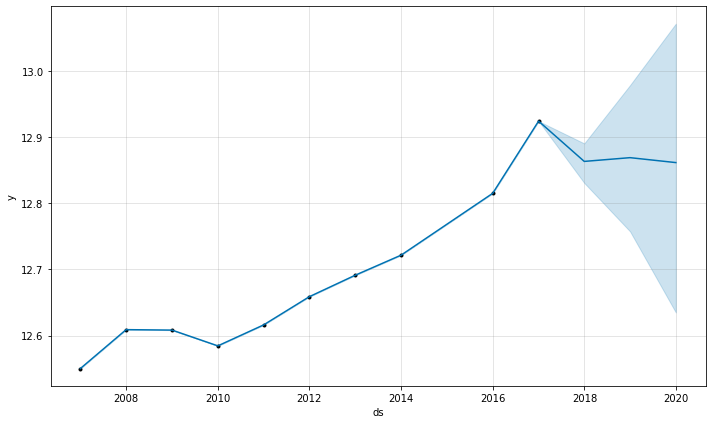

In [18]:
# m.plot_components(forecast)
fig1 = m.plot(forecast)

In [30]:
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
final.dtypes
final = final[['y', 'ds']]
final.set_index('ds', inplace=True)
final

,y
ds,
2007-01-01,12.550231
2008-01-01,12.609047
2009-01-01,12.608355
2010-01-01,12.584512
2011-01-01,12.616201
2012-01-01,12.658898
2013-01-01,12.691355
2014-01-01,12.721639
2016-01-01,12.815042


In [46]:
from pmdarima.arima import auto_arima

stepwise_model = auto_arima(final, error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
stepwise_model

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [37]:
results = stepwise_model.fit(final)

In [62]:
future_forecast = stepwise_model.predict(n_periods=3)
future_forecast
final

,y
ds,
2007-01-01,12.550231
2008-01-01,12.609047
2009-01-01,12.608355
2010-01-01,12.584512
2011-01-01,12.616201
2012-01-01,12.658898
2013-01-01,12.691355
2014-01-01,12.721639
2016-01-01,12.815042


In [73]:
from chart_studio.plotly import plot_mpl

s= [2019,2019,2020]
s = s.astype(int).apply(lambda x: pd.to_datetime(x, format='%Y'))
future_forecast = pd.DataFrame(future_forecast,index = s,columns=['y'])
future_forecast

AttributeError: 'list' object has no attribute 'astype'

In [68]:
total = pd.concat([final,future_forecast])

total.dtypes

y    float64
dtype: object

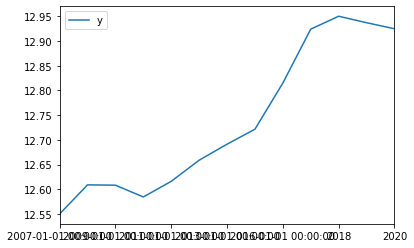

In [65]:
total.plot(kind= 'line')